# 21 - 元学习器

简单回顾一下，我们现在关注的是发现处理效应的异质性，也就是识别不同单位对处理的反应差异。在这个框架下，我们希望估计

$
\tau(x) = E[Y_i(1) − Y_i(0)|X] = E[\tau_i|X]
$

或者在连续处理的情况下，估计 $E[\delta Y_i(t)|X]$。换句话说，我们想知道各单位对处理的敏感程度。当我们不能对所有人都实施处理、必须对某些人进行优先排序时，这一点非常有用，例如当你想发放折扣但预算有限时。

之前，我们看到了如何通过变换结果变量 $Y$，将其输入预测模型，从而得到条件平均处理效应（CATE）的估计。那种做法的代价是增加了估计的方差。这在数据科学中很常见：不存在唯一最好的方法，每种方法都有其优点和缺点。因此，掌握多种技术并根据情境权衡使用是值得的。本章的精神就是为你提供更多工具。

![img](./images/21/learned-new-move.png)

元学习器是一种利用现成的预测性机器学习方法来解决同样问题——估计 CATE——的简单方式。同样地，没有一种方法是万能的，每一种都有其薄弱之处。我会尝试逐一介绍这些方法，但请记住，这些方法高度依赖于具体背景。此外，元学习器用到的预测性机器学习模型可以是线性回归、提升树、神经网络或高斯过程，成功与否很大程度上取决于所用的机器学习基学习器。通常你需要尝试多种不同的组合才能找到最佳方案。

In [127]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from nb21 import cumulative_gain, elast

这里，我们继续使用之前的投资广告邮件数据。目标仍然是弄清楚谁对邮件反应更好。不过这次有一个小变化：我们将用非随机的数据来训练模型，用随机的数据来验证模型。处理非随机数据要困难得多，因为元学习器既需要对数据进行去偏处理，又需要估计 CATE。

In [130]:
test = pd.read_csv("./data/invest_email_rnd.csv")
train = pd.read_csv("./data/invest_email_biased.csv")
train.head()

,age,income,insurance,invested,em1,em2,em3,converted
0,44.1,5483.80,6155.29,14294.81,0,0,1,0
1,39.8,2737.92,50069.40,7468.15,1,0,0,0
2,49.0,2712.51,5707.08,5095.65,0,0,1,1
3,39.7,2326.37,15657.97,6345.20,0,0,0,0
4,35.3,2787.26,27074.44,14114.86,1,1,0,0


我们的结果变量是 `conversion`，处理变量是 `email-1`。让我们创建一些变量来存储这二者，以及我们用来寻找处理效应异质性的特征 $X$。

In [133]:
y = "converted"
T = "em1"
X = ["age", "income", "insurance", "invested"]

## S-学习器（又称 “Go-Horse” 学习器）

第一个使用的学习器是 S-学习器。这是我们能够想到的最简单的学习器。我们将使用一个单一的（因此称 S）机器学习模型 $M_s$ 来估计

$
\mu(x) = E[Y| T, X]
$

为此，只需在预测结果 $Y$ 的模型中将处理作为一个特征加入即可。

```note
虽然我将使用一个回归模型来估计 E[Y| T, X]，但由于结果变量是二元的，你也可以使用分类器。只需要调整代码，使模型输出概率而不是二元类别 0、1。
```


In [136]:
from lightgbm import LGBMRegressor

np.random.seed(123)
s_learner = LGBMRegressor(max_depth=3, min_child_samples=30, force_col_wise=True, verbose=-1)
s_learner.fit(train[X+[T]], train[y]);

然后，我们可以在不同的处理状态下做出预测。预测值之间的差异就是我们的 CATE 估计

$
\hat{\tau}(x)_i = M_s(X_i, T=1) - M_s(X_i, T=0)
$

如果用图示表示，大致如下：

![img](./images/21/s-learner.png)

现在，让我们看看如何在代码中实现这种学习器。

In [139]:
s_learner_cate_train = (s_learner.predict(train[X].assign(**{T: 1})) -
                        s_learner.predict(train[X].assign(**{T: 0})))

s_learner_cate_test = test.assign(
    cate=(s_learner.predict(test[X].assign(**{T: 1})) - # predict under treatment
          s_learner.predict(test[X].assign(**{T: 0}))) # predict under control
)

为了评估这个模型，我们将查看测试集上的累积增益曲线。我还绘制了训练集上的增益曲线。由于训练集存在偏差，这条曲线不能说明模型是否良好，但它可以提示我们是否在训练集上过拟合。当发生过拟合时，训练集的曲线会异常之高。如果想看看这种情况的样子，可以把 `max_depth` 参数从 3 调整到 20。

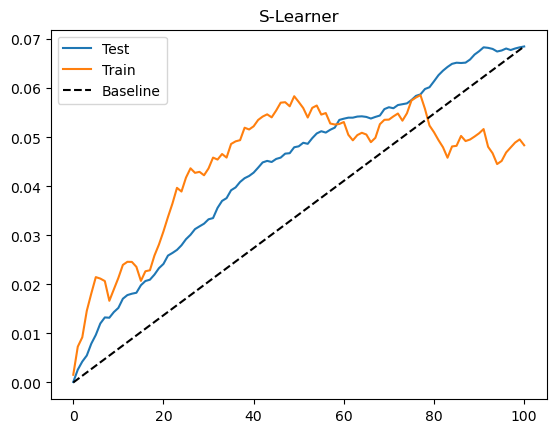

In [142]:
gain_curve_test = cumulative_gain(s_learner_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=s_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend()
plt.title("S-Learner");

![img](./images/21/not-great-not-terrible.jpeg)

从累积增益曲线可以看出，虽然简单，S-学习器在这个数据集上表现还可以。需要记住的是，这种表现高度依赖于数据集的特点。根据你手头数据的类型，S-学习器可能表现更好或更差。实践中，我发现 S-学习器由于简单，是任何因果问题的一个良好出发点。不仅如此，S-学习器既能处理连续处理，也能处理离散处理，而本章的其他学习器只能处理离散处理。

S-学习器的主要缺点是倾向于将处理效应偏向零。由于 S-学习器通常使用正则化的机器学习模型，正则化会限制估计的处理效应。Chernozhukov 等 (2016) 用模拟数据说明了这个问题：

![img](./images/21/zero-bias-s-learner.png)

他们绘制了真实因果效应（红色外框）与估计的因果效应之差 $\tau - \hat{\tau}$。可以看出估计的因果效应偏差很大。

更糟的是，如果处理变量相对于其他协变量对结果的影响非常弱，S-学习器可能完全丢弃处理变量。请注意，这与所选择的机器学习模型密切相关。正则化越强，这个问题越严重。下一节将介绍一种尝试解决这一问题的学习器。

## T-学习器

T-学习器试图通过强制学习器首先根据处理进行分割来解决完全忽略处理的问题。与使用单个模型不同，我们将为每个处理取值估计一个模型。在二元处理的情况下，我们只需要估计两个模型（因此名为 T）：

$
\mu_0(x) = E[Y| T=0, X]
$

$
\mu_1(x) = E[Y| T=1, X]
$

然后，在预测时，我们可以对每个处理水平进行反事实预测并得到 CATE：

$
\hat{\tau}(x)_i = M_1(X_i) - M_0(X_i)
$

下面是该学习器的示意图：

![img](./images/21/t-learner.png)

现在，关于理论就这些。让我们动手编写代码。

In [146]:
np.random.seed(123)

m0 = LGBMRegressor(max_depth=2, min_child_samples=60, force_col_wise=True, verbose=-1)
m1 = LGBMRegressor(max_depth=2, min_child_samples=60, force_col_wise=True, verbose=-1)

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])

# estimate the CATE
t_learner_cate_train = m1.predict(train[X]) - m0.predict(train[X])
t_learner_cate_test = test.assign(cate=m1.predict(test[X]) - m0.predict(test[X]))

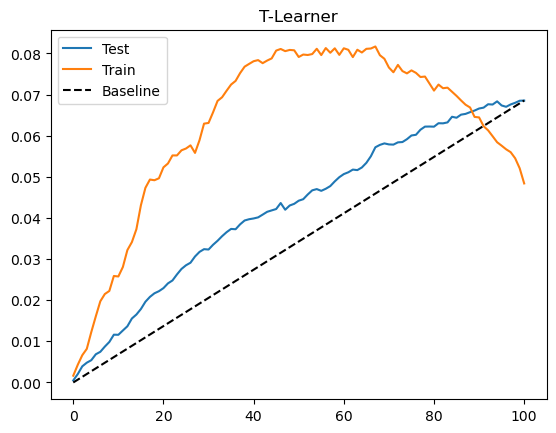

In [148]:
gain_curve_test = cumulative_gain(t_learner_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=t_learner_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("T-Learner");

T-学习器在这个数据集上的表现也不错。测试集的表现与 S-学习器差别不大，可能是因为处理本身并不弱。同时我们看到训练集的表现远高于测试集，这表明模型过拟合。这是因为我们为每个处理水平只在子样本上拟合模型，数据量减少时模型可能学到噪声。

T-学习器避免了对弱处理变量视而不见的问题，但仍然可能受到正则化偏差的影响。考虑 Kunzel 等人 (2019) 中的以下情形：你有大量未处理的数据，却只有很少的处理过的数据，这是许多应用中的常见情况，因为处理往往很昂贵。假设结果 $Y$ 存在某些非线性，但**处理效应是常数**。可以在下图中看到会发生什么：

![img](./images/21/t-learner-problem.png)

在这里，由于处理观测很少，为了避免过拟合，$M_1$ 会非常简单（在图中是线性的）。$M_0$ 会更复杂，但由于数据充足，不会过拟合。这在机器学习的角度看都是合理的。然而，如果我们用这些模型计算 CATE $\hat{\tau} = M_1(X) - M_0(X)$，那么线性的 $M_1(X)$ 减去非线性的 $M_0(X)$ 会得到一个非线性的 CATE（蓝线减红线），这显然是错误的，因为此例中的真实 CATE 是常数并等于 1。

问题在于，未处理组的模型可以捕捉非线性，而处理组模型由于用正则化应对样本小而无法捕捉。如果减少正则化以捕捉非线性，那么样本小又会导致过拟合。这似乎进退维谷。为解决这个问题，我们可以使用 X-学习器，这正是 Kunzel 等人论文中提出的方法。

## X-学习器

X-学习器比前两个学习器解释起来复杂得多，但其实现其实很简单，所以不用担心。X-学习器有两个阶段，并会用到一个倾向得分模型。第一阶段与 T-学习器完全相同：我们将样本按是否接受处理分为两组，并为处理组和控制组分别拟合一个机器学习模型。

$
\hat{M}_0(X) \approx E[Y| T=0, X]
$

$
\hat{M}_1(X) \approx E[Y| T=1, X]
$

现在事情开始有点不同。第二阶段，我们使用上述模型来填补控制组和处理组的处理效应：

$
\hat{\tau}(X, T=0) = \hat{M}_1(X, T=0) - Y_{T=0}
$

$
\hat{\tau}(X, T=1) = Y_{T=1} - \hat{M}_0(X, T=1)
$

然后，我们再拟合两个模型来预测这些效应：

$
\hat{M}_{\tau 0}(X) \approx E[\hat{\tau}(X)|T=0]
$

$
\hat{M}_{\tau 1}(X) \approx E[\hat{\tau}(X)|T=1]
$

如果我们将其应用到前面显示的图像中，$\hat{\tau}(X, T=0)$，即对未处理单位填补的处理效应，是图中的红色叉号，红色虚线则表示 $\hat{M}_{\tau 0}(X)$。注意这个模型是错误的，因为 $\hat{\tau}(X, T=0)$ 是用简单的、正则化的模型 $\hat{M}_1$（在处理组上估计）得到的，它未能捕捉 $Y$ 中的非线性，导致估计的处理效应具有非线性。

相反，蓝点是对处理组填补的处理效应 $\hat{\tau}(X, T=1)$。这些效应是用正确的模型 $M_0$（在未处理的大样本上训练）估计的。因此，由于填补的处理效应是正确的，我们能够训练出正确的第二阶段模型 $\hat{M}_{\tau 1}(X)$，如蓝线所示。

![img](./images/21/second-stage-x.png)

因此我们有一个模型是错误的，因为我们填补的处理效应是错误的，另一个模型是正确的，因为我们填补的效应是正确的。现在，我们需要一种方法来组合这两个模型，使正确模型的权重更高。这就需要倾向得分模型。设 $\hat{e}(x)$ 为倾向得分模型，我们可以如下组合两个第二阶段模型：

$
\hat{\tau}(x) = \hat{M}_{\tau 0}(X)\hat{e}(x) + \hat{M}_{\tau 1}(X)(1 - \hat{e}(x))
$

由于处理单位很少，$\hat{e}(x)$ 很小。这会给错误模型 $\hat{M}_{\tau 0}(X)$ 极小的权重。

相反，$1 - \hat{e}(x)$ 接近 1，因此我们会给予正确模型 $\hat{M}_{\tau 1}(X)$ 较大的权重。更一般地，使用倾向得分的加权平均确保我们给予在处理赋值较为可能的区域训练得到的 CATE 模型更多权重。换句话说，我们会偏好使用更多数据训练出的模型。下图展示了 X-学习器和 T-学习器估计的 CATE。

![img](./images/21/t-vs-x-learner.png)

如图所示，与 T-学习器相比，X-学习器在非线性区域纠正错误的 CATE 估计方面效果更好。一般而言，当一个处理组远大于另一个时，X-学习器表现更佳。

我知道这听起来信息很多，但在实现时希望会更清晰。为了总结一切，下面是该学习器的示意图。

![img](./images/21/x-learner.png)

最后让我们看代码实现。首先是第一阶段，这与 T-学习器完全一样。

In [152]:
from sklearn.linear_model import LogisticRegression

np.random.seed(123)

# first stage models
m0 = LGBMRegressor(max_depth=2, min_child_samples=30, force_col_wise=True, verbose=-1)
m1 = LGBMRegressor(max_depth=2, min_child_samples=30, force_col_wise=True, verbose=-1)

# propensity score model
g = LogisticRegression(solver="lbfgs", penalty=None) 

m0.fit(train.query(f"{T}==0")[X], train.query(f"{T}==0")[y])
m1.fit(train.query(f"{T}==1")[X], train.query(f"{T}==1")[y])
                       
g.fit(train[X], train[T]);

现在，我们根据填补的处理效应来拟合第二阶段模型。

In [155]:
d_train = np.where(train[T]==0,
                   m1.predict(train[X]) - train[y],
                   train[y] - m0.predict(train[X]))

# second stage
mx0 = LGBMRegressor(max_depth=2, min_child_samples=30, force_col_wise=True, verbose=-1)
mx1 = LGBMRegressor(max_depth=2, min_child_samples=30, force_col_wise=True, verbose=-1)

mx0.fit(train.query(f"{T}==0")[X], d_train[train[T]==0])
mx1.fit(train.query(f"{T}==1")[X], d_train[train[T]==1]);

最后，我们使用倾向得分模型对预测进行校正。

In [158]:
def ps_predict(df, t): 
    return g.predict_proba(df[X])[:, t]
    
    
x_cate_train = (ps_predict(train,1)*mx0.predict(train[X]) +
                ps_predict(train,0)*mx1.predict(train[X]))

x_cate_test = test.assign(cate=(ps_predict(test,1)*mx0.predict(test[X]) +
                                ps_predict(test,0)*mx1.predict(test[X])))

让我们看看 X-学习器在测试集上的表现。同样，我们绘制累积增益曲线。

/Users/zhe/文档/python-causality-handbook-zh/causal-inference-book/nb21.py:9: RuntimeWarning: invalid value encountered in scalar divide
  return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /


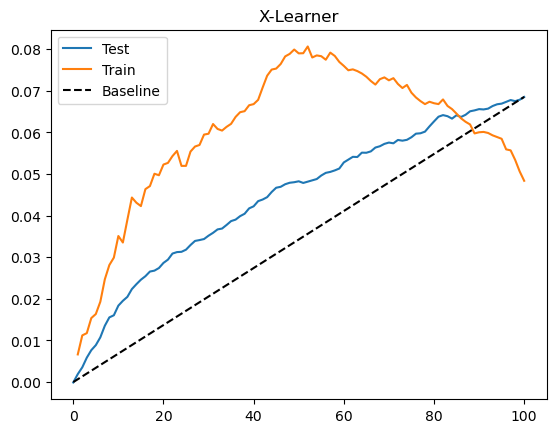

In [161]:
gain_curve_test = cumulative_gain(x_cate_test, "cate", y="converted", t="em1")
gain_curve_train = cumulative_gain(train.assign(cate=x_cate_train), "cate", y="converted", t="em1")
plt.plot(gain_curve_test, color="C0", label="Test")
plt.plot(gain_curve_train, color="C1", label="Train")
plt.plot([0, 100], [0, elast(test, "converted", "em1")], linestyle="--", color="black", label="Baseline")
plt.legend();
plt.title("X-Learner");

再一次，在这个数据集上我们的模型表现尚可。这里 S、T、X 学习器的表现似乎非常相似。不过，我仍然认为了解所有这些元学习器很有价值，这样你就可以选择最适合自己的方法。请记住，模型的表现也高度依赖于所选的基础机器学习模型。本章中我们使用的是梯度提升树，但也许其他模型或相同模型使用不同的超参数会更好。

## 关键观点

最简单的做法是使用单一模型的 S-学习器，将处理变量作为一个特征。这在处理变量不是弱预测因子时往往效果不错。但如果不是这种情况，S-学习器的估计会偏向零，甚至可能完全忽略处理变量。稍微复杂一些，我们可以使用 T-学习器，强制学习器分开拟合每个处理水平的模型。当每个处理水平都有足够样本时，这种方法很好用；但当某个处理水平样本很少时，模型会被迫强烈正则化而产生偏差。为了解决这个问题，我们可以再增加一个层次的复杂性，使用 X-学习器：它有两阶段拟合，并使用倾向得分模型来纠正由于样本过少导致的潜在错误。

这些学习器的一个大问题是（除了 S-学习器之外）都假设处理是二元或类别型的。还有一种更一般的学习器——R-学习器——我们尚未介绍。但不用担心，后面会有专门的一章讨论它。

## 参考说明

本章内容主要基于作者个人的经验总结，许多观点和方法源自实践中的体会。因此，无法提供严格意义上的学术参考文献。与正规科研工作不同，这些内容没有经过系统性的学术审查，也未经过同行评议与理论论证。读者或许会注意到，本文更多讨论的是“实践中有效的方法”，而非详细阐述其背后的理论基础。这种方法可以被视为“来自一线的经验科学”（a sort of science from the streets）。尽管如此，既然这些内容已公开发布，也非常欢迎批评与反馈——如果读者发现其中有明显错误或不妥之处，欢迎提出 issue，作者会尽力回应。

最后，对于那些希望系统学习机器学习的读者，作者也意识到本章的讲解可能过于简略。坦率地说，作者认为自己真正能够贡献价值的领域是因果推断的教学，而非机器学习。机器学习领域已有大量优质的公开资源，远超作者所能提供的内容。其中的经典之作，就是 [Andrew Ng 的机器学习课程](https://www.coursera.org/learn/machine-learning)，如果读者是机器学习初学者，作者强烈推荐认真学习这门课程。


## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立助理教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。